## [[DSC-2024](https://comp.ita.br/dsc/edicoes/2024/)] Develop a predictive model for the presence of hold(s) in commercial flights with origin and destination at the 12 main airports in Brazil

### Author: [Lucas Lima](https://www.linkedin.com/in/lucaslima25/)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

from pathlib import Path
from datetime import datetime

In [2]:
sys.path.append(str(Path().cwd().parent))

from prediction import NeuralNetwork, XgBoost

In [3]:
plt.rcParams["figure.dpi"] = 100

In [4]:
%reload_ext watermark
%watermark -a "xxx Team" --iversions

Author: xxx Team

matplotlib: 3.8.0
seaborn   : 0.13.0
numpy     : 1.24.3
sys       : 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pandas    : 2.1.4



In [5]:
df_balanced = pd.read_csv(f"../../data/preprocessing/df_padding_50_drop_0.csv")

In [6]:
df_prediction = pd.read_csv(f"../../data/preprocessing/df_prediction_padding_50_drop_0.csv", index_col='flightid')

In [7]:
df_original = pd.read_csv(f"../../data/base/public.csv")
df_original.sample(3)

,flightid,hora_ref,origem,destino,url_img_satelite,metaf,metar,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera
73370,c778f3de2df30feac618a68d1f479949,2022-09-02T15:00:00Z,SBRF,SBGL,http://satelite.cptec.inpe.br/repositoriogoes/...,METAF SBGL 021500Z 05005KT CAVOK 24/12 Q1016=,METAR SBGL 021400Z 04006KT 010V080 CAVOK 26/11...,0,1,0.0
169005,662ef023c917411a4ea8c56d382c7457,2022-12-28T10:00:00Z,SBPA,SBRF,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBRF 280900Z 12008KT 9999 SCT020 27/22 Q...,1,0,0.0
86316,6485e2a6f68412879747b8f4c0c190b5,2022-09-19T12:00:00Z,SBSP,SBRJ,http://satelite.cptec.inpe.br/repositoriogoes/...,NaN,METAR SBRJ 191100Z 33004KT 290V360 9999 FEW015...,0,0,1.0


In [8]:
df_balanced.sample(3)

,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,metar_CAVOK,metar_wind_direction,metar_wind_speed,metar_wind_gust,metar_temperature,metar_dewpoint,...,metaf_OVC_alt,distance,imageSatelite_red,imageSatelite_yellow,imageSatelite_green,imageSatelite_blue,hour,weekday,mounth,holiday_near
61246,SBSP,0,0,0.0,True,60.0,5.0,False,18.0,13.0,...,0,184.295958,0.0,35.902018,50.966146,3.191406,8,3,8,False
26230,SBSP,0,0,0.0,True,340.0,9.0,False,24.0,7.0,...,0,112.329871,0.0,0.000000,0.000000,0.000000,17,1,7,False
137098,SBSV,0,0,0.0,False,90.0,11.0,False,27.0,23.0,...,0,259.855729,0.0,0.000000,2.049154,8.027018,1,0,11,False


In [9]:
ratio_classes = 1

In [10]:
class_counts = df_balanced['espera'].value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

minority_data = df_balanced[df_balanced['espera'] == minority_class]
majority_data = df_balanced[df_balanced['espera'] == majority_class]

oversampled_minority_data = pd.concat([minority_data] * ratio_classes, ignore_index=True)
target_sample_size = len(oversampled_minority_data)
undersampled_majority_data = majority_data.sample(target_sample_size, random_state=42)

# Combinar de volta com os dados originais
df_balanced = pd.concat([undersampled_majority_data, oversampled_minority_data], ignore_index=True)

# Verificando os novos conteúdos
print(df_balanced['espera'].value_counts())

espera
0.0    3686
1.0    3686
Name: count, dtype: int64


### Modelo Preditivo

#### Rede Neural Artificial

In [11]:
nn = NeuralNetwork(target="espera", seed=25)

In [12]:
nn.build(
    df_balanced,
    task="classification",
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4
)


                Task: classification

                Total of registers: 7372
                Total of valid registers: 7341
                Total of invalid registers: 31

                Total of training registers: 5138
                Total of validation registers: 1102
                Total of test registers: 1101

                Features before preprocessing: 40
                Features after preprocessing: 48

                Numerical Features: ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior', 'metar_wind_direction', 'metar_wind_speed', 'metar_temperature', 'metar_dewpoint', 'metar_qnh', 'metar_visibility', 'metar_FEW_alt', 'metar_SCT_alt', 'metar_BKN_alt', 'metar_OVC_alt', 'metaf_wind_direction', 'metaf_wind_speed', 'metaf_temperature', 'metaf_dewpoint', 'metaf_qnh', 'metaf_visibility', 'metaf_FEW_alt', 'metaf_SCT_alt', 'metaf_BKN_alt', 'metaf_OVC_alt', 'distance', 'imageSatelite_red', 'imageSatelite_yellow', 'imageSatelite_green', 'imageSatelite_blue', 'hour', 'wee

In [13]:
nn.hyperparameter_optimization(
    n_trials=1,
    num_folds=4,
    info=True,
    search_space_dropout = [0.5],
    search_space_layers = [3],
    search_space_batch_size = [64],
    search_space_optimizer = ['Adam']
)

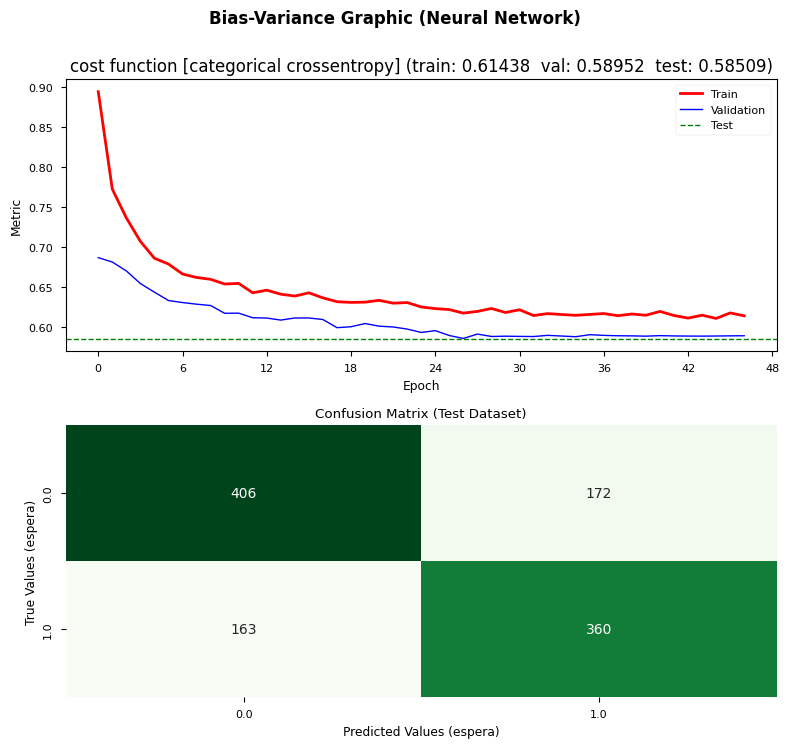

In [14]:
nn.fit(return_history=False, graphic=True, graphic_save_extension='png', verbose=0, path='../../models')

In [15]:
nn.save(path='../../models')

#### XG Boost

In [16]:
xgb = XgBoost(target="espera", seed=25)

In [17]:
xgb.build(
    df_balanced,
    task='classification',
    max_cat_nunique = 12,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20
)


                Task: classification

                Total of registers: 7372
                Total of valid registers: 7341
                Total of invalid registers: 31

                Total of training registers: 5138
                Total of validation registers: 1102
                Total of test registers: 1101

                Features before preprocessing: 40
                Features after preprocessing: 60

                Numerical Features: ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior', 'metar_wind_direction', 'metar_wind_speed', 'metar_temperature', 'metar_dewpoint', 'metar_qnh', 'metar_visibility', 'metar_FEW_alt', 'metar_SCT_alt', 'metar_BKN_alt', 'metar_OVC_alt', 'metaf_wind_direction', 'metaf_wind_speed', 'metaf_temperature', 'metaf_dewpoint', 'metaf_qnh', 'metaf_visibility', 'metaf_FEW_alt', 'metaf_SCT_alt', 'metaf_BKN_alt', 'metaf_OVC_alt', 'distance', 'imageSatelite_red', 'imageSatelite_yellow', 'imageSatelite_green', 'imageSatelite_blue', 'hour', 'wee

In [18]:
# xgb.load(path='../../models', foldername='xgBoost 18-04-24 23h20min')

In [19]:
xgb.hyperparameter_optimization(
    n_trials=1,
    num_folds=5,
    info=True,
    search_space_tree_method = ['gpu_hist'],
    search_space_booster = ['dart'], # 'gbtree', 'gblinear', 'dart'
    search_space_learning_rate = [0.1], # 0.2, 0.3
    search_space_min_split_loss = [0],
    search_space_max_depth = [8], # 5, 6, 7
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [32], # 256, 512
    search_space_num_parallel_tree = [1]
)

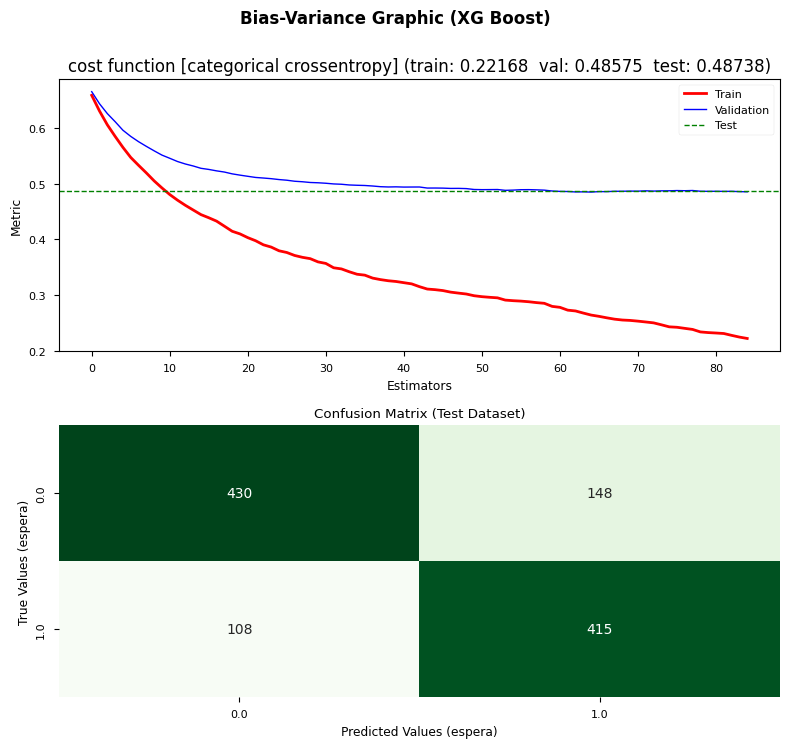

In [20]:
xgb.fit(return_history=False, graphic=True, graphic_save_extension='png', verbose=0, path='../../models')

In [21]:
xgb.save(path='../../models')

### Predição

In [22]:
pred_xgb = xgb.predict(df_prediction, bias_value=0.00)

Inference time: 691.87 milliseconds (90720 register(s))


In [23]:
pred_xgb.head(5)

,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,metar_CAVOK,metar_wind_direction,metar_wind_speed,metar_wind_gust,metar_temperature,metar_dewpoint,metar_qnh,...,distance,imageSatelite_red,imageSatelite_yellow,imageSatelite_green,imageSatelite_blue,hour,weekday,mounth,holiday_near,espera (XGB prediction)
flightid,,,,,,,,,,,,,,,,,,,,,
45e7978b9d88f934cc06c11b6f0edba7,SBKP,0,0,False,360.0,12.0,False,24.0,19.0,1011.0,...,91.087870,0.0,0.0,0.0,3.430339,13,3,2,False,0.0
16ed22b3755aa9196d16fdd2a173c98f,SBCF,0,0,False,180.0,5.0,False,23.0,19.0,1015.0,...,105.394497,0.0,0.0,0.0,5.089518,13,3,2,False,0.0
b548d2c700496e2536d78caf626aee17,SBSV,0,1,False,40.0,7.0,False,30.0,24.0,1011.0,...,317.845875,0.0,0.0,0.0,0.000000,13,3,2,False,0.0
e4cc2545104bcfe978912d39f0960f4e,SBBR,0,0,False,300.0,3.0,False,24.0,19.0,1016.0,...,180.235956,0.0,0.0,0.0,0.000000,13,3,2,False,0.0
ace87fdae884359186e9851c38b146fb,SBSP,0,1,False,340.0,13.0,False,23.0,18.0,1011.0,...,182.857868,0.0,0.0,0.0,0.038737,14,3,2,False,0.0


In [24]:
submission_xgb = pred_xgb[['espera (XGB prediction)']]

In [25]:
submission_xgb.columns = ['espera']

In [26]:
submission_xgb.head(5)

,espera
flightid,
45e7978b9d88f934cc06c11b6f0edba7,0.0
16ed22b3755aa9196d16fdd2a173c98f,0.0
b548d2c700496e2536d78caf626aee17,0.0
e4cc2545104bcfe978912d39f0960f4e,0.0
ace87fdae884359186e9851c38b146fb,0.0


In [27]:
submission_xgb.to_csv(f"../../data/submission/dsc_submission_{xgb.name}_ratio_classes_5x1_padding_50_drop_0_bias_0.0.csv", index=True)